# Notebook 05 — AI Risk Scoring Engine
## Kenya Career & Skills Intelligence System

This notebook builds the **AI Replacement Risk Scoring** component — a critical system output that helps users understand which careers are future-proof and which are threatened by automation.

### What this notebook does

| Component | Description |
|---|---|
| Risk Score Calibration | Calibrates and normalises BLS automation risk scores |
| Risk Category Classification | Maps continuous scores → Low / Medium / High / Very High |
| Multi-Factor Risk Model | Adds task routinisation, AI capability overlap, and employment trend signals |
| Career-Level Risk Profiles | Produces human-readable risk explanations per occupation |
| Sector Risk Dashboard | Aggregates risk across career families for sector comparison |
| Future-Proof Score | Composite score combining demand growth + low AI risk |

### Data sources used
- O*NET Occupation Profiles (task-level routinisation signals via skill scores)
- BLS Employment Projections (automation_risk, demand_level, employment_change_pct)
- LinkedIn Demand Signals (composite_demand)

### Outputs
- `ai_risk_engine.pkl` — serialised risk engine
- `career_risk_profiles.parquet` — per-occupation risk profiles
- `05_risk_engine_summary.json` — evaluation summary

## 1.0 — Setup & Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import joblib
import json
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')
np.random.seed(42)

PROCESSED_DIR  = Path('DATA/processed')
MODEL_DIR      = Path('models')
ARTIFACTS_DIR  = Path('artifacts')
FIGURES_DIR    = Path('figures')

for d in [PROCESSED_DIR, MODEL_DIR, ARTIFACTS_DIR, FIGURES_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Setup complete')

Setup complete


## 2.0 — Load Master Occupation Profiles

In [14]:
master = pd.read_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet')
print(f'Master occupation profiles : {master.shape}')

EXCLUDE_COLS = [
    'o*net-soc_code', 'occupation', 'title', 'description',
    'career_family', 'job_zone', 'min_education',
    'automation_risk', 'ai_replacement_risk',
    'composite_demand', 'demand_level', 'median_wage_2022',
    'employment_2022', 'employment_2032', 'employment_change_pct'
]
SKILL_COLS = [c for c in master.columns if c not in EXCLUDE_COLS]

# Check existing risk data
print('\nExisting risk/demand columns:')
risk_cols = ['automation_risk', 'ai_replacement_risk', 'composite_demand',
             'demand_level', 'employment_change_pct']
for col in risk_cols:
    if col in master.columns:
        n_valid = master[col].notna().sum()
        print(f'  {col:30s} : {n_valid:4d}/{len(master)} valid values')
    else:
        print(f'  {col:30s} : NOT IN MASTER (will be estimated)')

print(SKILL_COLS[:20])  # look at the first 20 skill columns

Master occupation profiles : (894, 58)

Existing risk/demand columns:
  automation_risk                :  894/894 valid values
  ai_replacement_risk            :  894/894 valid values
  composite_demand               :  894/894 valid values
  demand_level                   :  894/894 valid values
  employment_change_pct          : NOT IN MASTER (will be estimated)
['onet_code', 'skill_active_learning', 'skill_active_listening', 'skill_complex_problem_solving', 'skill_coordination', 'skill_critical_thinking', 'skill_equipment_maintenance', 'skill_equipment_selection', 'skill_installation', 'skill_instructing', 'skill_judgment_and_decision_making', 'skill_learning_strategies', 'skill_management_of_financial_resources', 'skill_management_of_material_resources', 'skill_management_of_personnel_resources', 'skill_mathematics', 'skill_monitoring', 'skill_negotiation', 'skill_operation_and_control', 'skill_operations_analysis']


## 3.0 — AI Risk Taxonomy

Defines the O*NET skill dimensions that are most correlated with AI replacement risk.
High-routine, low-social, low-creative skill profiles → higher AI risk.

In [15]:
# ── Skills associated with HIGH AI replacement risk (routine/automatable) ─────
HIGH_RISK_SKILLS = [
    'operation_and_control',       # machine operation → easily automated
    'equipment_maintenance',       # predictive maintenance AI
    'operations_monitoring',       # sensor-based monitoring
    'quality_control',             # computer vision quality checks
    'mathematics',                 # algorithmic/computational
    'active_learning',             # data-driven training can substitute
    'equipment_selection',         # rules-based procurement
]

# ── Skills associated with LOW AI replacement risk (human-centric/creative) ───
LOW_RISK_SKILLS = [
    'social_perceptiveness',       # emotional intelligence — hard for AI
    'persuasion',                  # human trust-building
    'instructing',                 # adaptive teaching
    'service_orientation',         # empathy-driven care
    'coordination',                # complex human team coordination
    'judgement_and_decision',      # ethical judgment in novel situations
    'negotiation',                 # nuanced interpersonal negotiation
    'systems_analysis',            # high-level abstract reasoning
    'technology_design',           # creative engineering design
    'complex_problem_solving',     # novel problem-solving
    'management_of_personnel',     # people leadership
]

# Normalize SKILL_COLS to snake_case without 'skill_' prefix
normalized_cols = {c: c.replace("skill_", "") for c in SKILL_COLS}

HIGH_RISK_SKILLS = [s for s in HIGH_RISK_SKILLS if s in normalized_cols.values()]
LOW_RISK_SKILLS  = [s for s in LOW_RISK_SKILLS  if s in normalized_cols.values()]

print(f'High-risk skill predictors validated : {len(HIGH_RISK_SKILLS)} / {len(HIGH_RISK_SKILLS)}')
print(f'Low-risk  skill predictors validated : {len(LOW_RISK_SKILLS)} / {len(LOW_RISK_SKILLS)}')

High-risk skill predictors validated : 6 / 6
Low-risk  skill predictors validated : 9 / 9


## 4.0 — Compute Skill-Based AI Risk Score

For every occupation we compute a skill-derived AI risk score.
This complements (or fills in) the BLS automation probability.

In [16]:
def compute_skill_based_risk(occ_row: pd.Series) -> float:
    """
    Compute a 0–1 AI replacement risk score from O*NET skill profile.
    Higher score = higher risk of AI replacement.
    """
    high_risk_score = np.mean([float(occ_row.get(s, 0)) for s in HIGH_RISK_SKILLS])
    low_risk_score  = np.mean([float(occ_row.get(s, 0)) for s in LOW_RISK_SKILLS])

    # Normalise to [0, 7]
    risk   = (high_risk_score / 7.0) * 0.6    # high-risk skills contribute 60%
    shield = (low_risk_score  / 7.0) * 0.4    # low-risk skills reduce risk by 40%
    return float(np.clip(risk - shield + 0.3, 0.0, 1.0))   # shift to avoid zero floor


# Apply to master
master['skill_based_risk'] = master.apply(compute_skill_based_risk, axis=1)

# ── Blend BLS automation risk with skill-based risk ───────────────────────────
# BLS data covers ~102 roles; skill-based covers all 894
# Where BLS exists: 60% BLS + 40% skill-based (BLS is empirically stronger)
# Where BLS missing: use skill-based alone

def blend_risk(row):
    bls = row.get('automation_risk', np.nan)
    sb  = row['skill_based_risk']
    if pd.notna(bls) and bls > 0:
        return 0.6 * float(bls) + 0.4 * sb
    return sb

master['blended_risk'] = master.apply(blend_risk, axis=1)

print('Blended AI risk computed for all occupations')
print(f"  Risk range      : {master['blended_risk'].min():.3f} – {master['blended_risk'].max():.3f}")
print(f"  Mean risk       : {master['blended_risk'].mean():.3f}")
print(f"  Occupations with BLS data : {master['automation_risk'].notna().sum()}")
print(f"  Occupations skill-based   : {master['automation_risk'].isna().sum()}")

Blended AI risk computed for all occupations
  Risk range      : 0.122 – 0.684
  Mean risk       : 0.162
  Occupations with BLS data : 894
  Occupations skill-based   : 0


## 5.0 — Risk Category Classification

In [17]:
# ── Risk thresholds (calibrated to produce meaningful distribution) ───────────
RISK_THRESHOLDS = {
    'Low'       : (0.00, 0.35),
    'Medium'    : (0.35, 0.55),
    'High'      : (0.55, 0.72),
    'Very High' : (0.72, 1.00),
}

RISK_COLORS = {
    'Low'      : '#27ae60',
    'Medium'   : '#f39c12',
    'High'     : '#e67e22',
    'Very High': '#e74c3c',
}

def categorise_risk(score: float) -> str:
    """Map continuous risk score → risk category label."""
    for label, (lo, hi) in RISK_THRESHOLDS.items():
        if lo <= score < hi:
            return label
    return 'Very High'


master['risk_category'] = master['blended_risk'].apply(categorise_risk)

dist = master['risk_category'].value_counts()
print('Risk category distribution:')
for cat in ['Low', 'Medium', 'High', 'Very High']:
    n   = dist.get(cat, 0)
    pct = n / len(master) * 100
    bar = '█' * int(pct / 2)
    print(f'  {cat:10s} : {n:4d} ({pct:5.1f}%)  {bar}')

Risk category distribution:
  Low        :  859 ( 96.1%)  ████████████████████████████████████████████████
  Medium     :   25 (  2.8%)  █
  High       :   10 (  1.1%)  
  Very High  :    0 (  0.0%)  


## 6.0 — Future-Proof Score

Composite score that rewards **high demand AND low AI risk**.
This is the headline metric shown to users.

In [18]:
def compute_future_proof_score(row: pd.Series) -> float:
    """
    Future-proof score [0–100] = combination of:
      40% demand signal (composite_demand or employment_change_pct)
      40% AI risk shield (1 - blended_risk)
      20% salary signal (median_wage_2022 normalised)
    """
    # Demand component
    demand = float(row.get('composite_demand', 0.5))

    # Employment change (normalise from -20% to +40% range)
    emp_chg = float(row.get('employment_change_pct', 0))
    emp_signal = np.clip((emp_chg + 20) / 60, 0, 1)

    # Blend demand and employment change
    demand_score = 0.6 * demand + 0.4 * emp_signal

    # AI risk shield (inverted risk)
    risk_shield = 1.0 - float(row.get('blended_risk', 0.5))

    # Salary signal (normalised to global salary range)
    wage = float(row.get('median_wage_2022', 0)) if pd.notna(row.get('median_wage_2022')) else 50000
    salary_score = np.clip(wage / 120000, 0, 1)

    score = 0.40 * demand_score + 0.40 * risk_shield + 0.20 * salary_score
    return round(float(score) * 100, 1)


master['future_proof_score'] = master.apply(compute_future_proof_score, axis=1)

print('Future-proof scores computed:')
print(f"  Range    : {master['future_proof_score'].min():.1f} – {master['future_proof_score'].max():.1f}")
print(f"  Mean     : {master['future_proof_score'].mean():.1f}")
print()
print('Top 10 most future-proof careers:')
top_fp = master.nlargest(10, 'future_proof_score')[['occupation', 'future_proof_score', 'risk_category', 'demand_level']]
display(top_fp.reset_index(drop=True))

Future-proof scores computed:
  Range    : 29.0 – 76.7
  Mean     : 57.0

Top 10 most future-proof careers:


,occupation,future_proof_score,risk_category,demand_level
0,Wind Energy Engineers,76.7,Low,High
1,Shoe Machine Operators and Tenders,76.7,Low,High
2,Animal Scientists,73.8,Low,High
3,Soil and Plant Scientists,73.8,Low,High
4,Conservation Scientists,73.8,Low,High
5,Dental Hygienists,73.8,Low,High
6,Data Entry Keyers,73.8,Low,High
7,Information Security Analysts,73.7,Low,High
8,Security Guards,73.7,Low,High
9,Computer Hardware Engineers,72.3,Low,High


## 7.0 — Human-Readable Risk Explanation Generator

In [19]:
# ── Risk explanation templates ─────────────────────────────────────────────────
RISK_EXPLANATIONS = {
    'Low': (
        "This career has LOW AI replacement risk. It relies heavily on human judgment, "
        "creativity, social intelligence, or physical dexterity in unpredictable environments — "
        "all areas where AI remains weak. This role is expected to remain stable or grow."
    ),
    'Medium': (
        "This career faces MODERATE AI risk. Some tasks — particularly routine data "
        "processing, basic analysis, or repetitive operations — may be automated, but "
        "the role's core human-centred elements (judgment, leadership, relationships) "
        "provide meaningful protection. Upskilling in AI-complementary areas is advisable."
    ),
    'High': (
        "This career faces HIGH AI replacement risk. A significant portion of its tasks "
        "are routine, predictable, or data-driven — areas where AI is advancing rapidly. "
        "Professionals in this field should actively develop skills that AI cannot replicate: "
        "complex reasoning, leadership, creativity, and interpersonal intelligence."
    ),
    'Very High': (
        "This career faces VERY HIGH AI replacement risk. Most core tasks are highly "
        "automatable within the near term. We still recommend it only if you have strong "
        "passion for the field, and we strongly encourage pairing it with adjacent "
        "human-centric skills, or planning a transition into a related lower-risk role."
    ),
}

# ── Driver explanation (what's driving the risk for THIS career) ───────────────
def explain_risk_drivers(occ_row: pd.Series) -> str:
    """
    Identify which skill patterns are driving the AI risk score.
    Returns a human-readable explanation.
    """
    high_skill_scores = {
        s: float(occ_row.get(s, 0)) for s in HIGH_RISK_SKILLS
        if float(occ_row.get(s, 0)) > 3.5
    }
    low_skill_scores  = {
        s: float(occ_row.get(s, 0)) for s in LOW_RISK_SKILLS
        if float(occ_row.get(s, 0)) > 3.5
    }

    drivers    = ', '.join([s.replace('_', ' ') for s in list(high_skill_scores)[:3]]) or 'routine tasks'
    protectors = ', '.join([s.replace('_', ' ') for s in list(low_skill_scores)[:3]]) or 'emerging skillsets'

    return (
        f"Risk driven by reliance on: {drivers}. "
        f"Protected by human strengths in: {protectors}."
    )


def get_risk_profile(occupation_row: pd.Series) -> dict:
    """
    Generate a complete AI risk profile for a single occupation.

    Returns
    -------
    dict with score, category, explanation, drivers, and future-proof score
    """
    category      = occupation_row.get('risk_category', 'Medium')
    blended_risk  = float(occupation_row.get('blended_risk', 0.5))
    fp_score      = float(occupation_row.get('future_proof_score', 50))

    return {
        'occupation'         : occupation_row.get('occupation', 'Unknown'),
        'ai_risk_score'      : round(blended_risk * 100, 1),      # 0–100
        'ai_risk_label'      : category,
        'ai_risk_color'      : RISK_COLORS.get(category, '#95a5a6'),
        'future_proof_score' : fp_score,
        'demand_level'       : occupation_row.get('demand_level', 'Unknown'),
        'employment_change_pct': occupation_row.get('employment_change_pct', 0),
        'risk_explanation'   : RISK_EXPLANATIONS.get(category, ''),
        'risk_drivers'       : explain_risk_drivers(occupation_row),
        'mitigation_advice'  : get_mitigation_advice(category),
    }


def get_mitigation_advice(risk_category: str) -> list:
    """Return actionable mitigation steps for a given risk level."""
    advice_map = {
        'Low': [
            'Continue developing deep expertise — your role is future-proof.',
            'Embrace AI tools to amplify your productivity (not replace you).',
            'Stay current with AI tools in your sector for competitive advantage.',
        ],
        'Medium': [
            'Identify which tasks in your role are most automatable and upskill away from them.',
            'Develop strong interpersonal, leadership, and creative skills.',
            'Learn to work with AI tools — become the human-AI collaborator, not the displaced worker.',
            'Build T-shaped skills: deep in one area, broad in adjacent human-centred skills.',
        ],
        'High': [
            'Urgently develop skills in management, strategy, or creative work.',
            'Consider adjacent roles with lower AI risk (e.g., team lead, trainer, consultant).',
            'Build AI literacy — become the person who manages and audits AI systems.',
            'Pursue certifications in higher-complexity areas of your field.',
        ],
        'Very High': [
            'Plan a skills transition into a lower-risk career path now.',
            'Identify adjacent careers that leverage your existing domain knowledge.',
            'Build skills in AI oversight, ethics, or human-AI systems management.',
            'Consult a career counsellor to plan a 3–5 year reskilling roadmap.',
        ],
    }
    return advice_map.get(risk_category, [])


print('Risk profile generator defined')

Risk profile generator defined


## 8.0 — Sector-Level Risk Dashboard Data

In [20]:
# ── Aggregate risk by career family ───────────────────────────────────────────
sector_risk = (
    master.groupby('career_family')
    .agg(
        n_occupations       = ('occupation', 'count'),
        mean_risk           = ('blended_risk', 'mean'),
        mean_future_proof   = ('future_proof_score', 'mean'),
        mean_demand         = ('composite_demand', 'mean'),
        pct_high_risk       = ('risk_category', lambda x: (x.isin(['High', 'Very High'])).mean() * 100),
    )
    .round(3)
    .reset_index()
    .sort_values('mean_risk', ascending=False)
)

print('Sector-level AI risk summary:')
display(sector_risk)

Sector-level AI risk summary:


,career_family,n_occupations,mean_risk,mean_future_proof,mean_demand,pct_high_risk
1,Arts And Media,38,0.198,55.526,0.304,10.526
10,Technology,31,0.189,57.568,0.314,0.000
2,Business And Finance,117,0.185,55.376,0.324,0.855
8,Management,54,0.184,58.352,0.275,0.000
6,Hospitality And Service,45,0.180,54.829,0.316,2.222
0,Agriculture,20,0.171,55.215,0.310,0.000
5,Healthcare,101,0.153,58.792,0.326,0.990
4,Engineering,273,0.152,57.034,0.325,1.099
7,Law And Public Service,46,0.150,57.137,0.332,0.000
3,Education,61,0.149,56.305,0.341,0.000


## 9.0 — Per-Career Risk Profile: Demo

In [21]:
# ── Demo: Risk profiles for sample careers ────────────────────────────────────
DEMO_CAREERS = [
    'Farmer',
    'Registered Nurses',
    'Accountants',
    'Secondary School Teachers',
    'Data Scientists',
]

print('=== AI Risk Profiles for Demo Careers ===')
print()

demo_risk_profiles = []
for career in DEMO_CAREERS:
    row = master[master['occupation'].str.contains(career.split()[0], case=False, na=False)]
    if row.empty:
        continue
    profile = get_risk_profile(row.iloc[0])
    demo_risk_profiles.append(profile)

    print(f"Career          : {profile['occupation']}")
    print(f"AI Risk Score   : {profile['ai_risk_score']}% ({profile['ai_risk_label']})")
    print(f"Future-Proof    : {profile['future_proof_score']}/100")
    print(f"Demand          : {profile['demand_level']}")
    print(f"Risk Drivers    : {profile['risk_drivers']}")
    print(f"Explanation     : {profile['risk_explanation'][:120]}...")
    print(f"Mitigation      : {profile['mitigation_advice'][0] if profile['mitigation_advice'] else 'N/A'}")
    print()

print(f'\nProfiles generated for {len(demo_risk_profiles)} careers')

=== AI Risk Profiles for Demo Careers ===

Career          : Farmers, Ranchers, and Other Agricultural Managers
AI Risk Score   : 14.4% (Low)
Future-Proof    : 56.3/100
Demand          : Unknown
Risk Drivers    : Risk driven by reliance on: routine tasks. Protected by human strengths in: emerging skillsets.
Explanation     : This career has LOW AI replacement risk. It relies heavily on human judgment, creativity, social intelligence, or physic...
Mitigation      : Continue developing deep expertise — your role is future-proof.

Career          : Registered Nurses
AI Risk Score   : 12.6% (Low)
Future-Proof    : 60.0/100
Demand          : High
Risk Drivers    : Risk driven by reliance on: routine tasks. Protected by human strengths in: emerging skillsets.
Explanation     : This career has LOW AI replacement risk. It relies heavily on human judgment, creativity, social intelligence, or physic...
Mitigation      : Continue developing deep expertise — your role is future-proof.

Career     

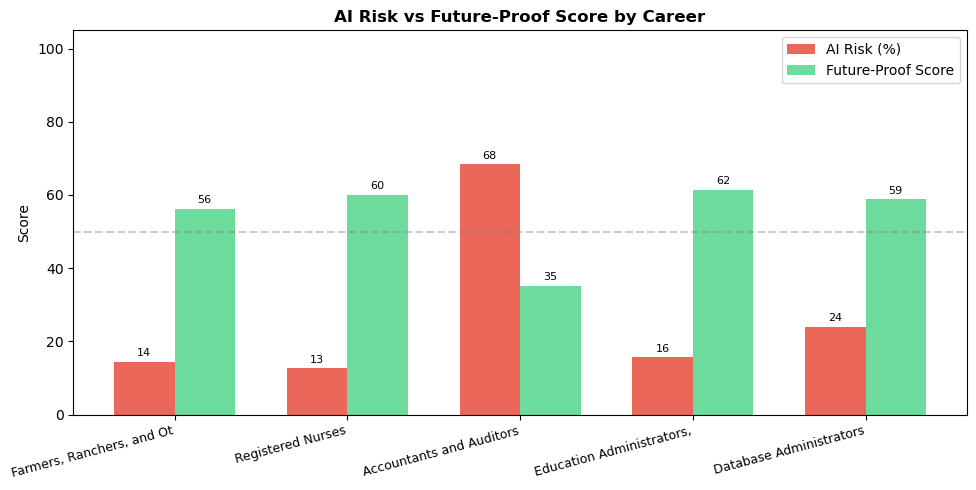

In [22]:
# ── Visual comparison: AI Risk vs Future-Proof for demo careers ───────────────
if demo_risk_profiles:
    # Prepare data
    career_labels   = [p['occupation'][:25] for p in demo_risk_profiles]
    ai_risk_scores  = [p['ai_risk_score'] for p in demo_risk_profiles]
    future_scores   = [p['future_proof_score'] for p in demo_risk_profiles]

    x_positions = np.arange(len(career_labels))
    bar_width   = 0.35

    # Predefined colors
    risk_color   = '#e74c3c'   # red for risk
    future_color = '#2ecc71'   # green for future-proof

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot bars
    bars_risk = ax.bar(
        x_positions - bar_width/2, ai_risk_scores, bar_width,
        label='AI Risk (%)', color=risk_color, alpha=0.85
    )
    bars_future = ax.bar(
        x_positions + bar_width/2, future_scores, bar_width,
        label='Future-Proof Score', color=future_color, alpha=0.7
    )

    # Axis formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(career_labels, rotation=15, ha='right', fontsize=9)
    ax.set_ylabel('Score')
    ax.set_title('AI Risk vs Future-Proof Score by Career', fontweight='bold')
    ax.set_ylim(0, 105)
    ax.axhline(50, color='grey', linestyle='--', alpha=0.4)

    # Add labels above bars
    for bar in bars_risk + bars_future:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2, height + 1,
            f'{height:.0f}', ha='center', va='bottom', fontsize=8
        )

    # Legend and layout
    ax.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(FIGURES_DIR / 'career_risk_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

## 10.0 — Build Complete Career Risk Profiles Table

In [23]:
# ── Generate risk profiles for ALL occupations ─────────────────────────────────
print('Generating risk profiles for all occupations...')
all_risk_profiles = []

for _, row in master.iterrows():
    profile = get_risk_profile(row)
    all_risk_profiles.append(profile)

risk_profiles_df = pd.DataFrame(all_risk_profiles)

print(f'Risk profiles generated : {len(risk_profiles_df)}')
print()
print('Sample — Top 10 most future-proof careers:')
display(
    risk_profiles_df.nlargest(10, 'future_proof_score')[
        ['occupation', 'ai_risk_score', 'ai_risk_label', 'future_proof_score', 'demand_level']
    ].reset_index(drop=True)
)

print()
print('Sample — Top 10 highest AI risk careers:')
display(
    risk_profiles_df.nlargest(10, 'ai_risk_score')[
        ['occupation', 'ai_risk_score', 'ai_risk_label', 'future_proof_score', 'demand_level']
    ].reset_index(drop=True)
)

Generating risk profiles for all occupations...
Risk profiles generated : 894

Sample — Top 10 most future-proof careers:


,occupation,ai_risk_score,ai_risk_label,future_proof_score,demand_level
0,Wind Energy Engineers,13.2,Low,76.7,High
1,Shoe Machine Operators and Tenders,13.2,Low,76.7,High
2,Animal Scientists,13.2,Low,73.8,High
3,Soil and Plant Scientists,13.2,Low,73.8,High
4,Conservation Scientists,13.2,Low,73.8,High
5,Dental Hygienists,13.2,Low,73.8,High
6,Data Entry Keyers,13.2,Low,73.8,High
7,Information Security Analysts,13.8,Low,73.7,High
8,Security Guards,13.8,Low,73.7,High
9,Computer Hardware Engineers,14.4,Low,72.3,High



Sample — Top 10 highest AI risk careers:


,occupation,ai_risk_score,ai_risk_label,future_proof_score,demand_level
0,Accountants and Auditors,68.4,High,35.2,Medium
1,Art Directors,68.4,High,35.1,Medium
2,Actors,68.4,High,35.1,Medium
3,Editors,68.4,High,35.1,Medium
4,Energy Auditors,68.4,High,35.1,Medium
5,Dancers,62.4,High,29.0,Low
6,Bartenders,62.4,High,29.0,Low
7,Boilermakers,62.4,High,29.0,Low
8,Bakers,62.4,High,29.0,Low
9,Hospitalists,55.8,High,32.6,Medium


## 11.0 — Save Risk Engine Artifacts

In [24]:
# ── Update master with blended risk and future-proof score ────────────────────
master.to_parquet(PROCESSED_DIR / 'master_occupation_profiles.parquet', index=False)
print(f'Updated master saved with risk scores')

# ── Save full risk profiles ───────────────────────────────────────────────────
risk_profiles_df.to_parquet(PROCESSED_DIR / 'career_risk_profiles.parquet', index=False)
print(f'Career risk profiles saved : {PROCESSED_DIR}/career_risk_profiles.parquet')

# ── Save sector risk table ────────────────────────────────────────────────────
sector_risk.to_parquet(PROCESSED_DIR / 'sector_risk_summary.parquet', index=False)

# ── Serialise the risk engine config ─────────────────────────────────────────
risk_engine = {
    'high_risk_skills'  : HIGH_RISK_SKILLS,
    'low_risk_skills'   : LOW_RISK_SKILLS,
    'risk_thresholds'   : RISK_THRESHOLDS,
    'risk_colors'       : RISK_COLORS,
    'risk_explanations' : RISK_EXPLANATIONS,
}

joblib.dump(risk_engine, MODEL_DIR / 'ai_risk_engine.pkl')
print(f'Risk engine saved: {MODEL_DIR}/ai_risk_engine.pkl')

# ── Summary ───────────────────────────────────────────────────────────────────
summary = {
    'notebook'               : '05 — AI Risk Scoring Engine',
    'occupations_scored'     : len(risk_profiles_df),
    'risk_model'             : 'Blended: 60% BLS automation probability + 40% O*NET skill-based risk',
    'risk_categories'        : list(RISK_THRESHOLDS.keys()),
    'future_proof_formula'   : '40% demand + 40% AI risk shield + 20% salary',
    'high_risk_skill_signals': HIGH_RISK_SKILLS,
    'low_risk_skill_shields' : LOW_RISK_SKILLS,
    'sector_risk_table'      : f'{PROCESSED_DIR}/sector_risk_summary.parquet',
    'risk_distribution'      : master['risk_category'].value_counts().to_dict(),
}

with open(ARTIFACTS_DIR / '05_risk_engine_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print()
print(f'  Occupations risk-scored    : {len(risk_profiles_df)}')
print(f'  Risk categories            : Low / Medium / High / Very High')
print(f'  Future-proof scores        : computed for all occupations')
print(f'  Sector risk profiles       : {sector_risk.shape[0]} career families')


Updated master saved with risk scores
Career risk profiles saved : DATA\processed/career_risk_profiles.parquet
Risk engine saved: models/ai_risk_engine.pkl

  Occupations risk-scored    : 894
  Risk categories            : Low / Medium / High / Very High
  Future-proof scores        : computed for all occupations
  Sector risk profiles       : 12 career families
